# IPSA 2021 - Exercise 3 - Fun with Fourier Transforms

## 0 - Practical Advice

In [1]:
import imageio 
import numpy as np
import numpy.fft as fft
import numpy.random as rnd
import scipy.ndimage as img
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import timeit, functools

In [2]:
def imageScaleRange(f, vmin=0, vmax=255):
    """Stretches the intensity values of a given image array f 
    such that they cover the whole range from 0 to 255"""
    return np.interp(f, (f.min(), f.max()), (vmin, vmax))

def imageRead(imgname, pilmode ='L', arrtype=float):
    """
    Read an image file into a numpy array

    imgname: str
        name of image file to be read
    pilmode: str
        for luminance / intesity images use ’L’
        for RGB color images use ’RGB’
    
    arrtype: numpy dtype
        use np.float, np.uint8, ...
    """
    return imageio.imread(imgname, pilmode=pilmode).astype(arrtype)

def imageWrite(arrF, imgname, arrtype=np.uint8):
    """
    Write a numpy array as an image file 
    the file type is inferred from the suffix of parameter imgname, e.g. ’.png’
    arrF: array_like
        array to be written
    imgname: str
        name of image file to be written
    arrtype: numpy dtype
        use np.uint8, ...
    """
    imageio.imwrite(imgname, arrF.astype(arrtype))

In [4]:
def writeFigure(fig, fname):
    fmt = fname.split('.')[-1]
    fig.savefig(fname, facecolor=fig.get_facecolor(), edgecolor='w',
                papertype='letter', format=fmt, transparent=False,
                bbox_inches='tight', pad_inches=0)

def plotFcts(x, fs,
             labs=None, lfs='x-small',
             xtcs=None, ytcs=None,
             lims=None, fname=None, title=None):

    # Initialize figure and axes
    fig = plt.figure()
    axs = fig.add_subplot(211, facecolor='w')

    # Nicer way of showing coordinate axes
    for pos in ['left','bottom']:
        axs.spines[pos].set_position('zero')
    for pos in ['right','top']:
        axs.spines[pos].set_visible(False)
        
    # Plot the function
    for f in fs:
        axs.plot(x, f, '-', alpha=0.75)

    # Plot the legend
    if labs is not None:
        axs.legend(labs, loc="upper right", fontsize=lfs,
                   facecolor='#e0e0e0', edgecolor='k', fancybox=False)

    if xtcs is not None: axs.set_xticks(xtcs)
    if ytcs is not None: axs.set_yticks(ytcs)
    
    if lims is not None:
        axs.set_xlim(lims[0], lims[1])
        axs.set_ylim(lims[2], lims[3])
        
    if title:
        plt.title(title)
        
        
    # Show figure on screen or write it to disc
    plt.show() if fname is None else writeFigure(fig, fname)
    plt.close()

## 1 - Uni-variate Gaussians and their derivatives

An unnormalized, uni-variate Gaussian function $f : \mathbb{R} \rightarrow \mathbb{R}$ with location parameter $\mu \in \mathbb{R}$ and scale parameter $\sigma \in \mathbb{R}_+$ is given by
\begin{equation}
f(x \mid \mu, \sigma) = \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} (x - \mu)^2}
\end{equation}
The following plot was created with parameters $\mu = 0$ and $\sigma \in \{ 0.5, 1.0, 2.0\}$ and illustrates how such functions look like for $x \in [-7, +7)$

![Gaussians1D-2.png](attachment:Gaussians1D-2.png)

### 1 (a) Compute the (symbolic) derivative of the Gaussian function

Using the chain rule: 
$$ f(x) = e^{u(x)} \ \implies \ f'(x) = u'(x) * e^{u(x)} $$

We can compute the derivative of the Gaussian function as:
\begin{align}
\frac{d}{dx} f(x \mid \mu, \sigma) 
&= \frac{d}{dx}\exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \frac{d}{dx}\Big[ - \frac{(x - \mu)^2}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \frac{d}{dx}\Big[ - \frac{x^2 -2x\mu + \mu^2}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= \Big[ - \frac{2x - 2\mu}{2 \, \sigma^2} \Big] \exp \left( - \frac{(x - \mu)^2}{2 \, \sigma^2}\right)\\
&= -\frac{(x- \mu)}{\sigma^2} f(x \mid \mu, \sigma)\\
&= \frac{(\mu - x)}{\sigma^2} f(x \mid \mu, \sigma)
\end{align}

### 1 (b) Use your result and the same parameters as above to create a plot that shows Gaussian derivatives and enter it here:

In [ ]:
def fctG(x, mu=0., sig=1.):
    """Gaussian function"""
    return np.exp(-0.5 * (x-mu)**2 / sig**2)

def ddxG(x, mu=0., sig=1.):
    """Derivative of the Gaussian function"""
    return -(x-mu) / sig**2 * fctG(x, mu, sig)

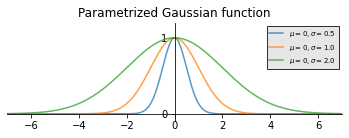

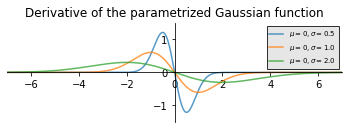

In [ ]:
xmin = -7
xmax = +7
rate = 1024
xval = np.linspace(xmin, xmax, rate, endpoint=False)

sigs = [0.5, 1.0, 2.0]
# Definine a legend for the plot
labs = [r'$\mu = 0, \sigma = %.1f$' % sig for sig in sigs]



# Plot three Gaussians
fcts = [fctG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -0.1, 1.2]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Parametrized Gaussian function")


# Plot their derivatives
fcts = [ddxG(xval, sig=sig) for sig in sigs]

lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]
plotFcts(xval, fcts, labs=labs,
         xtcs=xtcs, ytcs=ytcs, lims=lims, title="Derivative of the parametrized Gaussian function")

## 2 - Working with Labraries for Symbolic Computing

In this course, we work extensively with the python modules `numpy` / `scipy` because they provide numerous functionalities for numerical computing and number crunching. However, during the lectures, we also mentioned software for symbolic computation. Maybe you have come across such software before? Maybe you have heard of Wolfram Mathematica? For python, functionalities for symbolic computation are provided by the `sympy` module. To see what it buys you, execute the following snippet:

In [ ]:
! if conda list | grep sympy; then echo 1; else conda install -y sympy; fi

/bin/bash: conda: command not found
/bin/bash: conda: command not found


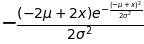

In [ ]:
from sympy import *
from IPython.display import display

init_printing(use_unicode=True)

x, mu, sigma = symbols('x mu sigma')

fctF = exp(-(x-mu)**2 / (2*sigma**2))

ddxF = Derivative(fctF, x)

display(ddxF.doit())

*Note that SymPy did not eliminate the $2/2$ factor like we did in task 1 a)*.

## 3 - Fourier Transforms of Gaussians and their Derivatives

**Note:** in what follows, we will (for convenience) simplify the Gaussian as well as our notation for this function. First of all, we will drop the location parameter $\mu$ (when creating the plots in task 3.1, we did set it to zero anyway). Second of all, we will no longer explicitly write the dependence on the scale parameter $\sigma$. In short, in what follows, we are concerned with Gaussians of the form:
\begin{equation}
f(x) = \exp \left( - \frac{x^2}{2 \, \sigma^2}\right) = e^{- \frac{1}{2 \, \sigma^2} x^2}
\end{equation}  

Observe that Gaussian functions are square integrable and therefore have Fourier transforms. In fact, the Fourier transforms of Gaussians centered at zero, i.e. without location parameter $\mu$, are remarkably simple. While the Fourier transform $F(\omega)$ of a function $f(x)$ is typically a complex valued function, the Fourier transform of a Gaussian centered at zero is a real valued function. You can work this out for yourselves (see solution of 3 a) for this).

### 3 (a) Symbolically compute the Fourier transform of the simplified version from above

Reference: https://docs.sympy.org/latest/modules/integrals/integrals.html#sympy.integrals.transforms.fourier_transform

In [ ]:
from sympy import fourier_transform, exp
from sympy.integrals.transforms import _fourier_transform
from sympy.abc import x, k, s

sigma = symbols('sigma')

FTf = fourier_transform(exp(-x**2/(2*sigma**2)), w, k)
display(FTf.doit())

gaussian = exp(-x**2/(2*sigma**2))
fct = _fourier_transform(gaussian, w, k, 1/sqrt(2*pi), -1, "", simplify=True)
display(fct.doit())

*Note: An unevaluated return indicates that SymPy was not able to calculate the Fourier Transform.*

#### Solution 1 - Using the given hints

We will make use of the given hint
$$ \int_{-\infty}^{\infty} \exp\big(- a y^2\big) \ dy = \sqrt{\frac{\pi}{a}} \tag{Eq. 1}$$
(Reference: [I.S. Gradshteyn and I.M. Ryzhik, “Table of Integrals, Series, and Prod-
ucts”, 8th edition, Academic Press, 2014](https://www.academia.edu/36550954/I_S_Gradshteyn_and_I_M_Ryzhik_Table_of_integrals_series_and_products_Academic_Press_2007_)

It is: 
\begin{align}
\mathcal{F}\{f(x)\} = F(\omega) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \exp(-i\omega x) \ dx \\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( - \big( \frac{x^2}{2\sigma^2} + i\omega x \big)\Big) \ dx \\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( -\frac{1}{2\sigma^2} \big( x^2 + i2\sigma^2 \omega x \big)\Big) \ dx \\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( -\frac{1}{2\sigma^2} \big( x^2 + i2\sigma^2 \omega x -\sigma^4\omega^2 + \sigma^4\omega^2 \big)\Big) \ dx && \text{adding zero/ binomial expansion}\\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( -\frac{1}{2\sigma^2} \big( (x + i\sigma^2\omega)^2 + \sigma^4\omega^2 \big)\Big) \ dx && \text{binomial formula}\\
&= \frac{1}{\sqrt{2\pi}} \exp\Big(-\frac{\sigma^4\omega^2}{2\sigma^2}\Big) \int_{-\infty}^{\infty} \exp\Big( -\frac{1}{2\sigma^2} (x + i\sigma^2\omega)^2 \Big) \ dx && \text{rearrange constants}\\
&= \frac{1}{\sqrt{2\pi}} \exp\Big(-\frac{\sigma^2\omega^2}{2}\Big) \int_{-\infty}^{\infty} \exp\Big( -\frac{1}{2\sigma^2} y^2 \Big) \ dy && \text{substitute: }y := x+i\sigma^2\omega\\
&= \frac{1}{\sqrt{2\pi}} \exp\Big(-\frac{\sigma^2\omega^2}{2}\Big) \sqrt{\frac{\pi}{a} } && \text{using (Eq. 1) with }a := \frac{1}{2\sigma ^2}\\
&= \frac{1}{\sqrt{2\pi}} \exp\Big(-\frac{\sigma^2\omega^2}{2}\Big) \sqrt{ 2 \sigma^2 \pi  } \\
&= \frac{\sqrt{ 2 \pi }}{\sqrt{2\pi}} \exp\Big(-\frac{\sigma^2\omega^2}{2}\Big) \sigma  \\
&= \sigma \exp\Big(-\frac{\sigma^2\omega^2}{2}\Big)  \\
\end{align}

#### Solution 2 - Using "*Abramowitz and Stegun*"

In the mathematical computation we will make use of the fact that $\sin(x)=\frac{1}{2i}\big( e^{ix} - e^{-ix} \big)$ and $\cos(x)=\frac{1}{2}\big( e^{ix} + e^{-ix} \big)$. More explicitly we will use that:
\begin{equation}
    \exp(-i\omega x) = \frac{1}{2} \big( e^{ix} - e^{-ix} \big)- \frac{1}{2}\big( e^{ix} + e^{-ix} \big) = \cos(\omega x) - i\sin(\omega x)
\end{equation}

With that in mind it is:
\begin{align}
\mathcal{F}\{f(x)\} = F(\omega) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \exp(-i\omega x) dx \\
&= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \Big( \cos(\omega x) - i \sin(\omega x) \Big) dx \\
&= \frac{1}{\sqrt{2\pi}} \Big[ \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(\omega x) dx - i \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \sin(\omega x) dx \Big]\\ 
&= \frac{1}{\sqrt{2\pi}} \Big[ \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(\omega x) dx + 0 \Big] &&\in\mathbb{R}
\end{align}

The second term is zero, since all occuring functions in the integral are odd ($\sin(x)=\sin(-x)$ and $x^2 = (-x)^2$), and the integral is computed over a symmetric domain.

We notice, that what remains is a **real valued** expression. This confirms the claim stated above!

To continue, we can use a result of [*Abramowitz and Stegun* "Handbook of Mathematical Functions", 1972; p. 302, equation 7.4.6](https://personal.math.ubc.ca/~cbm/aands/frameindex.htm), namely that for $\mathcal{Re}(a)>0$ it is:
\begin{align}
\int_{0}^{\infty} \exp ( -a x^2 ) \cos(2 x z ) dx \ = \ \frac{1}{2} \sqrt{\frac{\pi}{a}} \ \exp\Big(- \frac{z^2}{a}\Big)
\end{align}

We use it by identifying $a := \frac{1}{2\sigma^2}$ and $z = \frac{1}{2}\omega$. In order to have matching integral limits simply notice, that the term is even and thus can be computed by multiplying the integral from $0$ to $\infty$ with two:

\begin{align}
\mathcal{F}\{f(x)\} = F(\omega) &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(\omega x) \ dx \\ 
&= \frac{2}{\sqrt{2\pi}} \int_{0}^{\infty} \exp\Big( \frac{-x^2}{2\sigma^2} \Big) \cos(\omega x) \ dx \\
&= \frac{2}{\sqrt{2\pi}} \frac{1}{2} \sqrt{\frac{\pi}{a}} \ \exp\Big(- \frac{z^2}{a}\Big) \\
&= \frac{2}{\sqrt{2\pi}} \frac{1}{2} \sqrt{2\sigma^2 \pi} \ \exp\Big(- 2\sigma^2 \frac{1}{4} \omega^2 \Big) \\
&= \frac{\sqrt{2\sigma^2 \pi}}{\sqrt{2\pi}} \ \exp\Big(-\frac{1}{2} \sigma^2  \omega^2 \Big) \\
&= \sigma \ \exp\Big(- \frac{1}{2}\sigma^2\omega^2 \Big) 
\end{align}

### 3 (b) The Fourier transform of a zero mean Gaussian is another (scaled) Gaussian

To make a long story short, above you should have found that the Fourier transform of the Gaussian from above amounts to

$$ F(\omega) = \sigma \exp\Big(-\frac{1}{2} \sigma^2 \omega^2\Big)$$

Use this result to plot the Fourier transforms of zero mean Gaussians
with $\sigma \in \{0.5, 1.0, 2.0\}$ over the interval $\omega\in[−7, +7)$ and enter your
plot here:

In [ ]:
def spcG(x, sig=1.):
    """Simplified, zero mean Gaussian."""
    return np.exp(-0.5 * x**2 / sig**2)

def frqG(omega, sig=1.):
    """Fourier transform of the zero mean Gaussian"""
    return sig * spcG(omega, 1/sig)

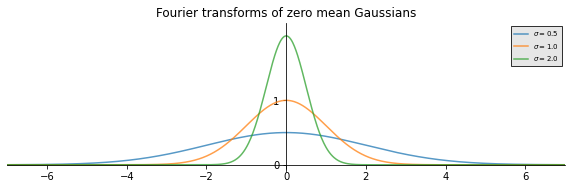

In [ ]:
omin = -7
omax = +7
rate = 1024
oval = np.linspace(omin, omax, rate, endpoint=False)


sigs = [0.5, 1.0, 2.0]
# Definine a legend for the plot
labs = [r'$\sigma = %.1f$' % sig for sig in sigs]


# Plot three Gaussian Fourier transforms
fcts = [frqG(oval, sig=sig) for sig in sigs]

lims = [omin, omax, -0.1, 2.2]
xtcs = np.arange(omin+1, omax, 2)
ytcs = [-1, 0, +1]
plotFcts(oval, fcts, labs=labs, xtcs=xtcs, ytcs=ytcs, lims=lims, title='Fourier transforms of zero mean Gaussians')

### 3 (c) Fourier transform of Gaussians with non-zero mean

At this point, you might (or better should) be wondering how to compute the Fourier transform of a Gaussian that is not centered
at zero but at some $\mu\neq 0$.

To answer this question, we can use the translation invariance of the Fourier transform we discussed in the lecture.
Note that we can shift the input variable by setting $x - \mu$, to obtain a translated Gaussian:

\begin{equation}
f(x-\mu) = \exp\Big( -\frac{(x-\mu)^2}{2\sigma^2} \Big)
\end{equation}

The Fourier transform of any translated function can be computed more simply, we get:

\begin{align}
\mathcal{F}\{f(x-\mu) \} &= \frac{1}{\sqrt{2\pi}} \ \int_{-\infty}^{\infty} e^{-\frac{(x-\mu)^2}{2 \sigma^2}} \ e^{-i\omega(x-\mu)} \ dx \\
&= \frac{1}{\sqrt{2\pi}} \ \int_{-\infty}^{\infty} e^{-\frac{(x-\mu)^2}{2 \sigma^2} } \ e^{-i\omega x}e^{i\omega\mu} \ dx \\
&= \frac{1}{\sqrt{2\pi}} e^{i\omega\mu} \ \int_{-\infty}^{\infty} e^{-\frac{(x-\mu)^2}{2 \sigma^2} } \ e^{-i\omega x} \ dx && \text{scaled integral} \\
&= \frac{1}{\sqrt{2\pi}} e^{i\omega\mu} \ \int_{-\infty}^{\infty} e^{-\frac{x^2}{2 \sigma^2} } \ e^{-i\omega x} \ dx && \text{index shift}\\
&= e^{i\omega\mu} \ \sigma \exp\Big( -\frac{1}{2}\omega^2\sigma^2 \Big) &&\text{using 3a)}\\ 
&= \sigma \exp\Big( -\frac{1}{2}\omega^2\sigma^2 \Big) \ \big( \cos(\omega \mu) + \sin(\omega \mu) \big)
\end{align}

What do you observe? Is the Fourier transform of a shifted or translated Gaussian still a real valued function?

No, the Fourier transform of the shifted/translated Gaussian is not a real valued function (since $\exp(i\omega \mu)$ is complex, if $\mu\neq 0$).

### 3 (d) Using the inverse Fourier transform to compute a derivative

Now that we know the Fourier transform of a zero mean Gaussian, we can use the inverse Fourier transform to compute the derivative of 
$$ f(x) = \exp\Big(-\frac{x^2}{2 \sigma^2 }\Big)$$

because
$$ \frac{\partial}{\partial x} f(x) = \mathcal{F}^{-1}\Big\{\mathcal{F}\Big\{ \frac{\partial}{\partial x} f(x) \Big\}\Big\} = \mathcal{F}^{-1} \{i\omega F(\omega)\} $$

Compute this inverse.

We will make use of the given hints
$$ \int_{-\infty}^{\infty} \exp\big(- a y^2\big) \ dy = \sqrt{\frac{\pi}{a}} \tag{Eq. 1}$$
and
$$ \int_{-\infty}^{\infty} y \exp\big(- a y^2\big) \ dy = 0 \tag{Eq. 2}$$
(Reference: [I.S. Gradshteyn and I.M. Ryzhik, “Table of Integrals, Series, and Prod-
ucts”, 8th edition, Academic Press, 2014](https://www.academia.edu/36550954/I_S_Gradshteyn_and_I_M_Ryzhik_Table_of_integrals_series_and_products_Academic_Press_2007_)

It is:
\begin{align}
\mathcal{F}^{-1} \{i\omega F(\omega)\} &= \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} i\omega \sigma \exp\Big( -\frac{1}{2} \sigma^2\omega^2 \Big) \exp\Big( i\omega x \Big) \ d\omega \\
&= \frac{i\sigma}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \omega \exp\Big( -\frac{1}{2} \sigma^2\omega^2 + i\omega x \Big) \ d\omega \\
&= \frac{i\sigma}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \omega \exp\Big(-\frac{\sigma^2}{2}\big(\omega^2 - \frac{2}{\sigma^2}i\omega x \big)\Big) \ d\omega \\
&= \frac{i\sigma}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \omega \exp\Big(-\frac{\sigma^2}{2}\big(\omega^2 - 2i\frac{1}{\sigma^2}\omega x -\frac{x^2}{\sigma^4}+\frac{x^2}{\sigma^4} \big)\Big) \ d\omega &&\text{adding zero}\\
&= \frac{i\sigma}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \omega \exp\Big(-\frac{\sigma^2}{2}\big( (\omega - \frac{ix}{\sigma^2})^2 + \frac{x^2}{\sigma^4} \big)\Big) \ d\omega &&\text{binomial expansion}\\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \int_{-\infty}^{\infty} \omega \exp\Big(-\frac{\sigma^2}{2}\big(\omega - \frac{ix}{\sigma^2}\big)^2 \Big) \ d\omega &&\text{rearranging constants}
\end{align}

We have now rearranged the integral, such that we can use the second hint - (Eq. 2). Therefore substitute $y := \omega - \frac{ix}{\sigma^2}$. This gives $\omega = y+\frac{ix}{\sigma^2}$:

\begin{align}
\mathcal{F}^{-1} \{i\omega F(\omega)\} &= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \int_{-\infty}^{\infty} \omega \exp\Big(-\frac{\sigma^2}{2}\big(\omega - \frac{ix}{\sigma^2}\big)^2 \Big) \ d\omega \\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \int_{-\infty}^{\infty} \Big( y + \frac{ix}{\sigma^2} \Big) \exp\Big(-\frac{\sigma^2}{2} y^2 \Big) \ d\omega \\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \Big[ \int_{-\infty}^{\infty} y \exp\Big(-\frac{\sigma^2}{2} y^2 \Big) \ dy \ \ + \ \ \int_{-\infty}^{\infty} \frac{ix}{\sigma^2} \exp\Big(-\frac{\sigma^2}{2} y^2 \Big) \ dy \Big]\\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \Big[ \int_{-\infty}^{\infty} \frac{ix}{\sigma^2} \exp\Big(-\frac{\sigma^2}{2} y^2 \Big) \ dy \Big] &&\text{using (Eq. 2)}\\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \frac{ix}{\sigma^2} \ \int_{-\infty}^{\infty} \exp\Big(-\frac{\sigma^2}{2} y^2 \Big) \ dy \\
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \frac{ix}{\sigma^2} \ \sqrt{\frac{\pi}{\frac{\sigma^2}{2}}} && \text{using (Eq. 1) with } a := \frac{\sigma^2}{2} \\ 
&= \frac{i\sigma}{\sqrt{2\pi}} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \frac{ix}{\sigma^2} \ \sqrt{\frac{2 \pi}{\sigma^2}} \\ 
&= \frac{i\sigma}{\sqrt{2\pi}} \frac{\sqrt{2 \pi}}{\sqrt{\sigma^2}} \frac{ix}{\sigma^2} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \\
&= \frac{-x}{\sigma^2} \exp\Big(-\frac{x^2}{2\sigma^2} \Big) \\ 
&= \frac{\partial}{\partial x} \exp\Big(-\frac{x^2}{2\sigma^2} \Big)
\end{align}

## 4 - Numerically computing Fourier Tranforms of Gaussians

n all the previous tasks of this exercise sheet, we were concerned with symbolic computations. Now, we will get back to numeric computations.

Our first corresponding task (this one) is a bit unusual in that we provide its solution. However, you really should carefully go through the following because it clarifies a critical issue you must know about. 

Above, you saw that the first derivative of a zero mean Gaussian can be computed as

$$ \frac{\partial}{\partial x} f(x) = \mathcal{F}^{-1}\Big\{\mathcal{F}\Big\{ \frac{\partial}{\partial x} f(x) \Big\}\Big\} = \mathcal{F}^{-1} \{i\omega F(\omega)\} $$

Let us verify this numerically. To this end, run the following snippet:

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


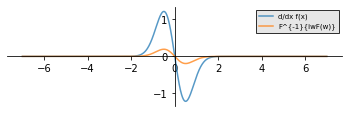

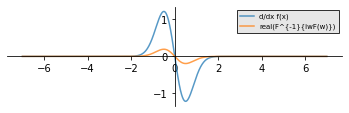

In [20]:
import numpy.fft as fft

N = 1024
xmin = -7
xmax = +7
x_val = np.linspace(xmin, xmax, N, endpoint=False)
omega_val = fft.fftfreq(N, (xmax-xmin)/N)

s = 0.5
f = np.exp(-0.5 * x_val**2 / s**2)
dfV1 = -x_val / s**2 * np.exp(-0.5 * x_val**2 / s**2)

# Compute the Fourier transform F(\omega)
F = fft.fft(f)

# Compute the inverse Fourier transform F^{-1){i \omega F(\omega)}
dfV2 = fft.ifft(1j * omega_val * F)

# Plot the results - the actual derivative ('dfV1') vs the one using the IFT ('dfV2')
labs = ["d/dx f(x)", "F^{-1}{iwF(w)}"]
plotFcts(x_val, [dfV1, dfV2], labs=labs)

dfV2 = np.real(dfV2)
labs = ["d/dx f(x)", "real(F^{-1}{iwF(w)})"]
plotFcts(x_val, [dfV1, dfV2], labs=labs)

What your inspection should have revealed is that there is still a systematic deviation between the content of array `dfV1` and array `dfV2`. Here is how to remedy this situation:

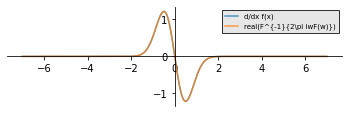

In [21]:
# Compute the inverse Fourier transform F^{-1){2\pi i \omega F(\omega)}
dfV2 = fft.ifft(2*np.pi * 1j * omega_val * F)
dfV2 = np.real(dfV2)

# Plot the results
lims = [xmin, xmax, -1.5, 1.5]
xtcs = np.arange(xmin+1, xmax, 2)
ytcs = [-1, 0, +1]

labs = ["d/dx f(x)", "real(F^{-1}{2\pi iwF(w)})"]
plotFcts(x_val, [dfV1, dfV2], labs=labs)

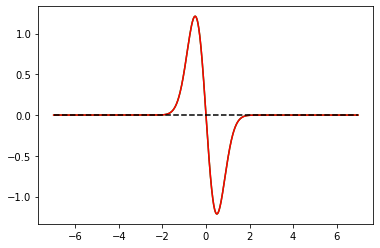

In [23]:
plt.plot(x_val, dfV1, '-', c='green')
plt.plot(x_val, dfV2, '-', c='red')
plt.plot(x_val, dfV2-dfV1, '--', c='black')
plt.show()

Now you should see that both arrays are basically identical (up to numerical precision). What is going on here? Why would a multiplication by a factor of $2\pi$ cause our practical computation to agree with our theoretical expectation?

The answer has to do with how we derived and subsequently defined the Fourier transform and its inverse.

Two key steps during our derivation were the introduction of the *angular frequency* $\omega = \frac{2 \pi}{T k}$ and the limiting process $T\to\infty$. Note, however, that there is no “canonical” way of writing down the Fourier transform and its inverse. There are only different “conventions”. Another common convention
is to consider the simple frequency $\xi = \frac{k}{T}$ and to let $T\to\infty$.

Considering the definition of $\xi$, we realize that we can write $\omega = 2\pi d\xi$ and thus $d\omega = 2 \pi d\xi$. 

\dots (see exercsie sheet for more explicit explanation). All in all, `fft.fft` and `fft.ifft` are defined w.r.t. to simple frequencies rather than w.r.t. angular frequencies. This is why we have to introduct the factor of $2\pi$ to get the expected result.

## 5 - Visualizing 2D Fourier transforms

In the *Data* folder for this exercise, you will find the intensity image `clock.jpg`. Read it into a numpy array `arrF` and run the following snippet:

In [30]:
# arrF = imageRead('../Data/clock.jpg')
arrF = imageRead('clock.jpg')
dftF = fft.fft2(arrF)
print(dftF.shape)
print(dftF)

print(dftF[0][0])

(256, 256)
[[ 1.15088260e+07     +0.j          1.28824751e+06-250936.18284767j
   4.53900763e+05 -31393.67792729j ...  2.77783329e+05 +48743.41796084j
   4.53900763e+05 +31393.67792729j  1.28824751e+06+250936.18284767j]
 [ 9.04217735e+05-492711.26267268j  2.13393152e+05+239871.45538753j
  -1.22518545e+05+147184.60504565j ... -2.08780731e+05 -57642.61793021j
  -1.14291842e+05+157732.48151541j  6.31979183e+05-168740.91561259j]
 [ 2.07063371e+05 -49353.31259129j  1.51577117e+05+130076.45911473j
  -3.78036403e+05 +45998.90759108j ... -1.16581105e+05 -70792.49288472j
  -3.82456345e+05 +76595.16949328j -1.00568857e+04+136096.61930981j]
 ...
 [ 1.88670285e+05 -48068.6835207j  -5.04911661e+04 -42347.26744512j
  -2.03105189e+05 +98457.37236341j ... -5.13798998e+04 +89973.68170474j
  -1.20973556e+05 +39215.54094375j -1.38441065e+04 +16105.60529832j]
 [ 2.07063371e+05 +49353.31259129j -1.00568857e+04-136096.61930981j
  -3.82456345e+05 -76595.16949328j ... -9.97549030e+04 +95944.19952628j
  -3.780

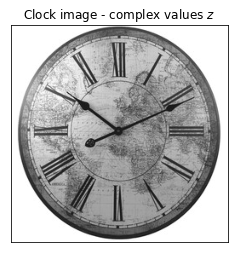

In [43]:
plt.imshow(arrF, cmap='gray')
plt.title("Clock image - complex values $z$")
plt.xticks([]); plt.yticks([])
plt.show()

You will find that dftF is a 2D array of complex numbers $z = a + i b = r e^{i\varphi}$. How to visualize such an array of complex numbers? The method we usually consider in this course is to consider their **magnitude** $r=|z|$. To compute and inspect these magnitudes, run the following:

In [47]:
magF = np.abs(dftF)

print(np.max(magF), np.min(magF))
print(magF[0,0])

11508826.0 15.327304343614227
11508826.0


What do you observe? How much larger is the value of `np.max(magF)` than the value of np.min(magF)? Only marginally larger? Or are we talking about orders of magnitude larger? Are the values of `np.max(magF)` and `magF[0,0]` the same? What it is that `magF[0,0]` represents?

In [48]:
print(np.max(magF) - np.min(magF))

11508810.672695657


The maximum value is orders of magnitue larger - it is the same as `magF[0,0]` which is the value of the pixel in the upper left corner and completely **white**.

To visualize collections of (positive) numbers of vastly different sizes, it is common to consider their logarithm:

16.25862486412334 2.792838819480752


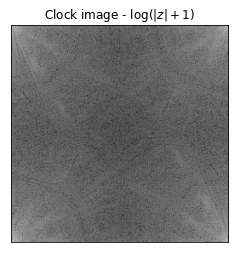

In [49]:
logMagF = np.log(magF + 1)
print(np.max(logMagF), np.min(logMagF))

# Print the logarithm of the image
plt.imshow(logMagF, cmap='gray')
plt.title("Clock image - $\log(|z| + 1)$")
plt.xticks([]); plt.yticks([])
plt.show()

Naturally, the logarithm diminishes the differences between the smallest and largest value.

255.0 0.0


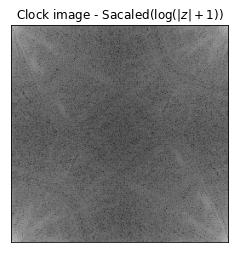

In [50]:
scaledLogMagF = imageScaleRange(logMagF)
print(np.max(scaledLogMagF), np.min(scaledLogMagF))

# Print the image
plt.imshow(scaledLogMagF, cmap='gray')
plt.title("Clock image - Sacaled$(\log(|z| + 1))$")
plt.xticks([]); plt.yticks([])
plt.show()

3.141592653589793 -3.1415855252416156


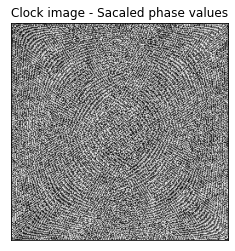

In [52]:
phsF = np.angle(dftF)
print (np.max(phsF), np.min(phsF))

# Print the image
plt.imshow(imageScaleRange(phsF), cmap='gray')
plt.title("Clock image - Sacaled phase values")
plt.xticks([]); plt.yticks([])
plt.show()

In [53]:
dftFshift = fft.fftshift(fft.fft2(arrF))

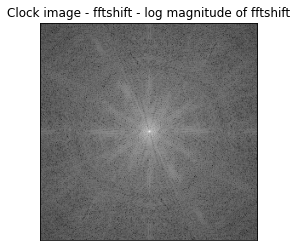

In [54]:
# Computing the logarithm on the magnitude shift
magFshift = np.abs(dftFshift)
logMagFshift = np.log(magFshift)
logMagFshift = imageScaleRange(logMagFshift)

# Print the image
plt.imshow(logMagFshift, cmap='gray')
plt.title("Clock image - fftshift - log magnitude of fftshift")
plt.xticks([]); plt.yticks([])
plt.show()

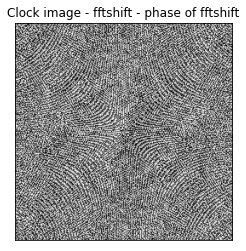

In [55]:
# Computing the angle / phase values
phsFshift = np.angle(dftFshift)
logFshift = imageScaleRange(phsFshift)

# Print the image
plt.imshow(logFshift, cmap='gray')
plt.title("Clock image - fftshift - phase of fftshift")
plt.xticks([]); plt.yticks([])
plt.show()

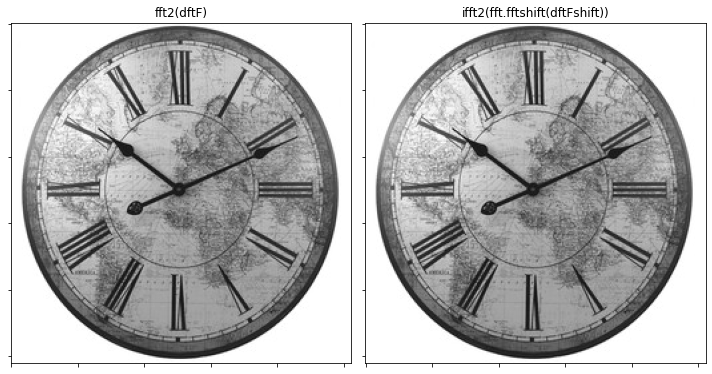

In [60]:
arrI = np.real(fft.ifft2(dftF))
arrJ = np.real(fft.ifft2(fft.fftshift(dftFshift)))

# Printing the images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(arrI, cmap='gray')
axs[0].set_title("fft2(dftF)")
axs[0].set_xticklabels([]); axs[0].set_yticklabels([]);

axs[1].imshow(arrJ, cmap='gray')
axs[1].set_title("ifft2(fft.fftshift(dftFshift))")
axs[1].set_xticklabels([]); axs[1].set_yticklabels([]);
fig.tight_layout()

plt.show()

## 6 - Exploring the Importance of Phase

Since the two intensity images `clock.jpg` ($g[x, y]$) and `portrait.png` ($h[x, y]$) in the Data folder for this exercise are of the same size ($256\times 256$ pixels), we can use them for an interesting experiment.

Write a program that reads the two images into memory.

In [61]:
# Reading the images into memory
#fctG = imageRead('../Data/clock.jpg')
fctG = imageRead('clock.jpg')
#fctH = imageRead('../Data/portrait.png')
fctH = imageRead('portrait.png')

Then, let you program compute the Fourier transforms
$$ G[\xi, \nu] = \mathcal{F}\{ g[x,y] \} \qquad\text{and}\qquad H[\xi, \nu] = \mathcal{F}\{ h[x,y] \}$$

In [63]:
# Computing their Fourier transform
dftG = fft.fft2(fctG)
dftH = fft.fft2(fctH)

In the previous task, you saw that we can think of the resulting complex valued functions as
$$ G[\xi, \nu] = G_r[\xi, \nu]\cdot \exp\big( i G_{\varphi}[\xi, \nu] \big) \qquad\text{and}\qquad H[\xi, \nu] = H_r[\xi, \nu]\cdot \exp\big( i H_{\varphi}[\xi, \nu] \big) \}$$

Hence, let your program compute the magnitude and phase functions
$$ G_r[\xi, \nu], \ G_{\varphi}[\xi, \nu], \ H_r[\xi, \nu] \ \text{and}  \ H_{\varphi}[\xi, \nu]$$

In [65]:
# Computing their magnitude and phase functions
dftGr = np.abs(dftG)
dfrGp = np.angle(dftG)
dftHr = np.abs(dftH)
dfrHp = np.angle(dftH)

Next, compute the following complex valued function where the magnitude information of $P$ comes from $G$ and the phase information comes form $H$:
$$P[\xi, \nu] = G_r[\xi, \nu] \cdot \exp\big( i H_{\varphi}[\xi, \nu] \big)  \qquad\text{and}\qquad  Q[\xi, \nu] = H_r[\xi, \nu] \cdot \exp\big( i G_{\varphi}[\xi, \nu] \big)$$

In [66]:
# Compute the complex value function G_r[\xi, \nu] \exp{i H_\varphi[\xi, \nu]}
dftP = dftGr * np.exp(1j * dfrHp)
dftQ = dftHr * np.exp(1j * dfrGp)

Finally, compute the inverse Fourier transforms
$$ p[x,y] = \mathcal{F}^{-1}\{ P[\xi,\nu] \} \qquad\text{and}\qquad q[x,y] = \mathcal{F}^{-1}\{ Q[\xi,\nu] \} $$

In [68]:
fctP = np.real(fft.ifft2(dftP))
fctQ = np.real(fft.ifft2(dftQ))

print(fctP.max(), fctP.min())
print(fctQ.max(), fctQ.min())

602.25687385722 -138.6134337607794
252.49085671835422 -10.856172128560416


And print them:

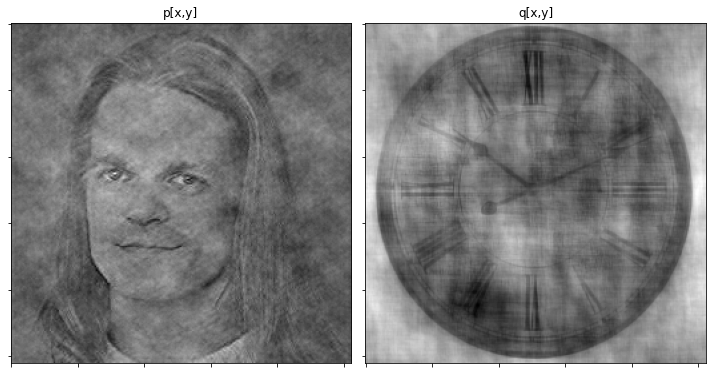

In [73]:
# Printing the images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(fctP, cmap='gray')
axs[0].set_title("p[x,y]")
axs[0].set_xticklabels([]); axs[0].set_yticklabels([]);

axs[1].imshow(fctQ, cmap='gray')
axs[1].set_title("q[x,y]")
axs[1].set_xticklabels([]); axs[1].set_yticklabels([]);
fig.tight_layout()

plt.show()

$$ p[x,y] = \mathcal{F}^{-1}\Big\{G_r[\xi, \nu] \cdot \exp\big( i H_{\varphi}[\xi, \nu] \big) \Big\} $$

$$ q[x,y] = \mathcal{F}^{-1}\Big\{H_r[\xi, \nu] \cdot \exp\big( i G_{\varphi}[\xi, \nu] \big) \Big\} $$

To obtain nicer looking digital images, you may apply `imageScaleRange`:

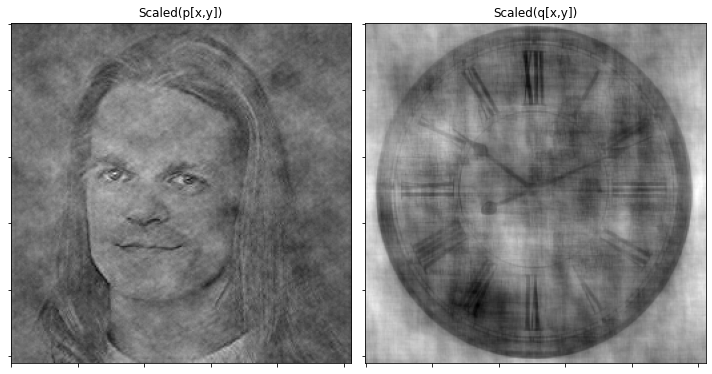

In [75]:
# Printing the images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].imshow(imageScaleRange(fctP), cmap='gray')
axs[0].set_title("Scaled(p[x,y])")
axs[0].set_xticklabels([]); axs[0].set_yticklabels([]);

axs[1].imshow(imageScaleRange(fctQ), cmap='gray')
axs[1].set_title("Scaled(q[x,y])")
axs[1].set_xticklabels([]); axs[1].set_yticklabels([]);
fig.tight_layout()

plt.show()

## 7 - Low-pass Filtering in the Frequency Domain

Once again read image `clock.jpg` into an array `arrF` and compute:

In [76]:
#arrF = imageRead('../Data/clock.jpg')
arrF = imageRead('clock.jpg')

dftF = fft.fftshift(fft.fft2(arrF))

Now, use what you learned in exercise 1, to set all those entries in array `dftF` to zero whose distance to the central element of dftF exceeds a value of `r` max . Recall that the $[i, j]$ coordinates of the central element of dftF can
be computed as `dftF.shape / 2`.

Store your result in an array `dftH`.

In [77]:
def lp(arrF, rmax):
    M, N = arrF.shape

    rs,cs = np.meshgrid(np.arange(M), np.arange(N), indexing='ij')
    dist2 = (rs-M/2)**2 + (cs-N/2)**2
    lpFlt = np.where(dist2 <= rmax**2, 1, 0)

    return arrF * lpFlt

Then, compute the following snippet:

104.13367469244714 247.08782188958412
75.41953907546065 285.4533419852616
60.9844964334937 298.9691535237219
10.300264983687683 283.36068117699017


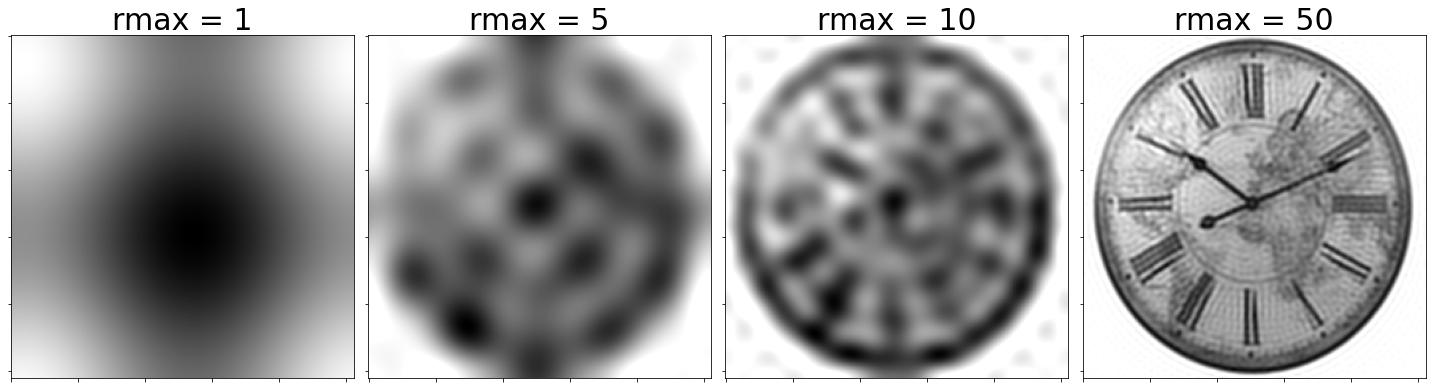

In [79]:
rmax_range = [1, 5, 10, 50]

fig, axs = plt.subplots(1, len(rmax_range), figsize=(20,20))

for i, rmax in enumerate(rmax_range):
    dftH = lp(dftF, rmax)
    arrH = np.real(fft.ifft2(fft.fftshift(dftH)))

    print (np.min(arrH), np.max(arrH))
    arrH = np.clip(arrH, 0, 255)

    ax = axs[i]
    ax.imshow(arrH, cmap='gray')    
    ax.set_title(f"rmax = {rmax}", fontsize=30)
    
    ax.set_xticklabels([]); ax.set_yticklabels([])    
    fig.tight_layout()

The results are blurred images. $\frac{1}{r_{\max}}$ indicates the strength of the effect.